In [1]:
import pandas as pd
import torch
import pickle
from datetime import datetime
import os

# Imports from our project
from src.utils.paths import PROJECT_ROOT
from src.utils.ontology_utils import load_ontology  # Still need this to access term names

# --- 1. Load Preprocessed Data Artifacts ---
# Instead of running preprocessing, we now load the files created by `run_preprocessing.py`.

# Hardcoded date for loading the preprocessed files
DATE = '2025-10-17'
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"

print(f"Loading data from: {PROCESSED_DATA_DIR} for date {DATE}")

# Load the ontology object to get term names for printing
cl = load_ontology()

# Load DataFrames
marginalization_df = pd.read_csv(PROCESSED_DATA_DIR / f"{DATE}_marginalization_df.csv", index_col=0)
parent_child_df = pd.read_csv(PROCESSED_DATA_DIR / f"{DATE}_parent_child_df.csv", index_col=0)
exclusion_df = pd.read_csv(PROCESSED_DATA_DIR / f"{DATE}_exclusion_df.csv", index_col=0)

# Load mapping_dict
mapping_dict_df = pd.read_csv(PROCESSED_DATA_DIR / f"{DATE}_mapping_dict_df.csv", index_col=0)
# The DataFrame was saved with CL numbers as the index and integer mappings in the first column
mapping_dict = pd.Series(mapping_dict_df.iloc[:, 0].values, index=mapping_dict_df.index).to_dict()

# Load leaf and internal values
with open(PROCESSED_DATA_DIR / f"{DATE}_leaf_values.pkl", "rb") as fp:
    leaf_values = pickle.load(fp)
with open(PROCESSED_DATA_DIR / f"{DATE}_internal_values.pkl", "rb") as fp:
    internal_values = pickle.load(fp)

print("\nAll data artifacts loaded successfully.")
print(f"Loaded {len(mapping_dict)} cell types.")
print(f"  - {len(leaf_values)} leaf nodes")
print(f"  - {len(internal_values)} internal nodes")




Loading data from: /home/jingqiao/real_McCell/data/processed for date 2025-10-17
Loading cached ontology from /home/jingqiao/real_McCell/data/processed/ontology.pkl...
Ontology loaded successfully.

All data artifacts loaded successfully.
Loaded 141 cell types.
  - 41 leaf nodes
  - 100 internal nodes


Data loader


In [2]:
import cellxgene_census
import tiledbsoma as soma
from tiledbsoma_ml import ExperimentDataset, experiment_dataloader
import pandas as pd

# Get all cell types from our mapping dict to build the query
all_cell_values = list(mapping_dict.keys())

# --- Load gene list from BioMart (matching old_reference approach) ---
print("Loading protein-coding genes from BioMart...")
biomart_path = PROJECT_ROOT / "hpc_workaround/data/mart_export.txt"
biomart = pd.read_csv(biomart_path)

# Filter for protein-coding genes only
coding_only = biomart[biomart['Gene type'] == 'protein_coding']
gene_list = coding_only['Gene stable ID'].tolist()

print(f"Loaded {len(gene_list)} protein-coding genes from BioMart")

# Create the 'value_filter' strings for the query
var_value_filter = f"feature_id in {gene_list}"
obs_value_filter = f"assay == '10x 3\\' v3' and is_primary_data == True and cell_type_ontology_term_id in {all_cell_values}"

print(f"Ready to query {len(all_cell_values)} cell types and {len(gene_list)} protein-coding genes.")

Loading protein-coding genes from BioMart...
Loaded 23262 protein-coding genes from BioMart
Ready to query 141 cell types and 23262 protein-coding genes.


In [3]:
# Point to the local SOMA database (which is already the homo_sapiens experiment)
soma_uri = "/scratch/sigbio_project_root/sigbio_project25/jingqiao/mccell-single/soma_db_homo_sapiens"
print(f"Opening local SOMA database at: {soma_uri}")

# Open the experiment directly (it's a SOMAExperiment, not a SOMACollection)
experiment = soma.open(soma_uri, mode="r")

# Create the ExperimentDataset and DataLoaders using the query filters
with experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter=obs_value_filter),
    var_query=soma.AxisQuery(value_filter=var_value_filter),
) as query:
    experiment_dataset = ExperimentDataset(
        query,
        obs_column_names=["cell_type_ontology_term_id"],
        layer_name="raw",
        batch_size=256,
        shuffle=True,
        seed=111
    )

    train_dataset, val_dataset = experiment_dataset.random_split([0.8, 0.2], seed=42)

    print(f'\nTotal matching cells: {len(experiment_dataset)}')
    print(f'Training set size: {len(train_dataset)}')
    print(f'Validation set size: {len(val_dataset)}')

    train_dataloader = experiment_dataloader(train_dataset)
    val_dataloader = experiment_dataloader(val_dataset)

# Show a summary of the loaded train and validation datasets
print("\nTrain dataset shape:", train_dataset.shape)
print("Validation dataset shape:", val_dataset.shape)

Opening local SOMA database at: /scratch/sigbio_project_root/sigbio_project25/jingqiao/mccell-single/soma_db_homo_sapiens

Total matching cells: 24936
Training set size: 19949
Validation set size: 4988

Train dataset shape: (19949, 20060)
Validation dataset shape: (4988, 20060)


In [4]:
from src.train.model import SimpleNN
from src.train.loss import MarginalizationLoss
import torch.optim as optim
import matplotlib.pyplot as plt

# --- 1. Setup ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# The input dimension is the number of genes from our dataset object
input_dim = train_dataset.shape[1]
output_dim = len(leaf_values)  # Model only predicts leaf nodes

model = SimpleNN(input_dim=input_dim, output_dim=output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Instantiate the new, correct loss function with all required artifacts
loss_fn = MarginalizationLoss(
    marginalization_df=marginalization_df,
    parent_child_df=parent_child_df,
    exclusion_df=exclusion_df,
    leaf_values=leaf_values,
    internal_values=internal_values,
    mapping_dict=mapping_dict,
    device=device
)

print("Model, optimizer, and loss function are ready.") 

Using device: cpu
Model, optimizer, and loss function are ready.


In [6]:
num_epochs = 10
batches_per_epoch = 200
batch_loss_history = []

print(f"\nStarting training for {num_epochs} epochs ({batches_per_epoch} batches each)...")
for epoch in range(num_epochs):
    model.train()
    print(f'\n--- Epoch {epoch + 1} ---')

    for i, (X_batch, obs_batch) in enumerate(train_dataloader):
        if i >= batches_per_epoch:
            break

        # Data preparation
        X_batch = torch.from_numpy(X_batch).float()
        X_batch = torch.log1p(X_batch)  # Log-transform gene expression
        X_batch = X_batch.to(device)
        
        label_strings = obs_batch["cell_type_ontology_term_id"]
        y_batch = torch.tensor([mapping_dict[term] for term in label_strings], device=device, dtype=torch.long)

        # Training step
        optimizer.zero_grad()
        outputs = model(X_batch)
        total_loss, loss_leafs, loss_parents = loss_fn(outputs, y_batch)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Logging
        batch_loss_history.append(total_loss.item())
        if (i + 1) % 50 == 0:
            print(f'  [Batch {i + 1:3d}] Total Loss: {total_loss.item():.4f} (Leaf: {loss_leafs.item():.4f}, Parent: {loss_parents.item():.4f})')

print('\nFinished Training.')



Starting training for 10 epochs (200 batches each)...

--- Epoch 1 ---
  [Batch  50] Total Loss: 6.3284 (Leaf: 6.1574, Parent: 0.1710)
  [Batch 100] Total Loss: 7.2957 (Leaf: 7.0925, Parent: 0.2032)
  [Batch 150] Total Loss: 4.6132 (Leaf: 4.3915, Parent: 0.2217)
  [Batch 200] Total Loss: 4.6230 (Leaf: 4.3664, Parent: 0.2566)

--- Epoch 2 ---
  [Batch  50] Total Loss: 1.1491 (Leaf: 0.9643, Parent: 0.1849)
  [Batch 100] Total Loss: 2.3545 (Leaf: 2.1403, Parent: 0.2142)
  [Batch 150] Total Loss: 1.5336 (Leaf: 1.3078, Parent: 0.2258)
  [Batch 200] Total Loss: 0.8071 (Leaf: 0.5525, Parent: 0.2546)

--- Epoch 3 ---
  [Batch  50] Total Loss: 0.4226 (Leaf: 0.2379, Parent: 0.1847)
  [Batch 100] Total Loss: 0.4132 (Leaf: 0.2041, Parent: 0.2091)
  [Batch 150] Total Loss: 1.5005 (Leaf: 1.2911, Parent: 0.2094)
  [Batch 200] Total Loss: 0.4435 (Leaf: 0.1896, Parent: 0.2540)

--- Epoch 4 ---
  [Batch  50] Total Loss: 0.3263 (Leaf: 0.1617, Parent: 0.1646)
  [Batch 100] Total Loss: 0.7457 (Leaf: 0.548

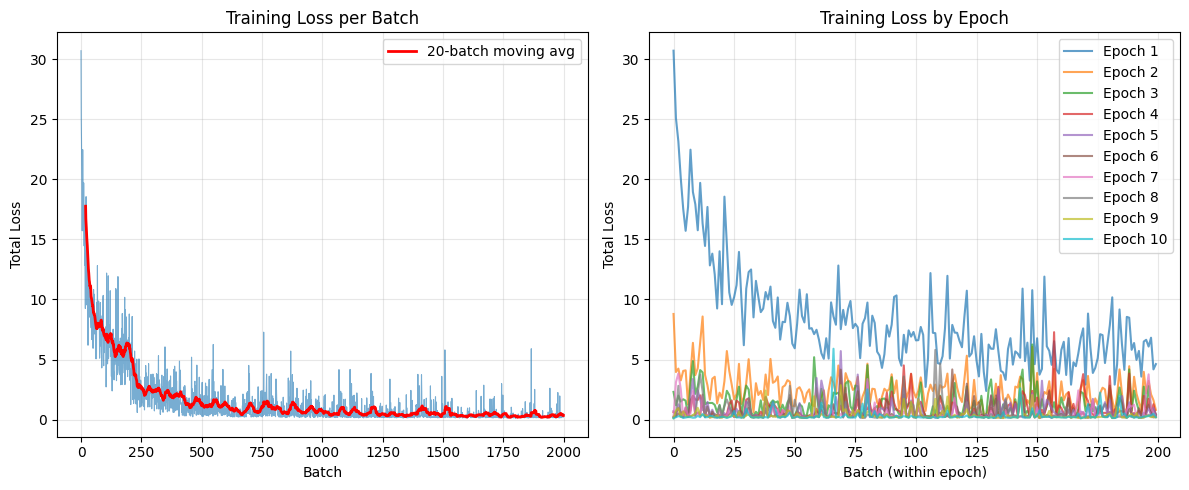


Training Summary:
  Initial loss: 30.6967
  Final loss: 0.2131
  Loss reduction: 99.3%


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot Training Loss ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_loss_history, alpha=0.6, linewidth=0.8)
plt.xlabel('Batch')
plt.ylabel('Total Loss')
plt.title('Training Loss per Batch')
plt.grid(True, alpha=0.3)

# Moving average for smoother trend
window_size = 20
if len(batch_loss_history) >= window_size:
    moving_avg = np.convolve(batch_loss_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(batch_loss_history)), moving_avg, 
             color='red', linewidth=2, label=f'{window_size}-batch moving avg')
    plt.legend()

plt.subplot(1, 2, 2)
# Plot loss by epoch (if multiple epochs)
if num_epochs > 1:
    epoch_losses = [batch_loss_history[i*batches_per_epoch:(i+1)*batches_per_epoch] 
                   for i in range(num_epochs)]
    for i, losses in enumerate(epoch_losses):
        plt.plot(losses, label=f'Epoch {i+1}', alpha=0.7)
    plt.xlabel('Batch (within epoch)')
    plt.ylabel('Total Loss')
    plt.title('Training Loss by Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Run multiple epochs\nto see comparison', 
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Initial loss: {batch_loss_history[0]:.4f}")
print(f"  Final loss: {batch_loss_history[-1]:.4f}")
print(f"  Loss reduction: {(1 - batch_loss_history[-1]/batch_loss_history[0])*100:.1f}%")

In [9]:
import numpy as np

# --- Validate the Model (LEAF NODES ONLY) ---
print("="*60)
print("VALIDATION (LEAF NODES ONLY)")
print("="*60)

model.eval()
val_batches = 50

val_total_losses = []
val_leaf_losses = []
val_parent_losses = []
all_predictions = []
all_labels = []

leaf_indices_set = {mapping_dict[cid] for cid in leaf_values}
total_samples = 0
leaf_samples = 0

with torch.no_grad():
    for i, (X_batch, obs_batch) in enumerate(val_dataloader):
        if i >= val_batches:
            break

        # Data preparation
        X_batch = torch.from_numpy(X_batch).float()
        X_batch = torch.log1p(X_batch)
        X_batch = X_batch.to(device)

        label_strings = obs_batch["cell_type_ontology_term_id"]
        y_batch = torch.tensor([mapping_dict[term] for term in label_strings],
                              device=device, dtype=torch.long)

        total_samples += len(y_batch)

        # FILTER: Only keep samples with LEAF node labels
        is_leaf = torch.tensor([y.item() in leaf_indices_set for y in y_batch], device=device)

        if is_leaf.sum() == 0:
            continue  # Skip batches with no leaf samples

        X_batch_leaf = X_batch[is_leaf]
        y_batch_leaf = y_batch[is_leaf]
        leaf_samples += len(y_batch_leaf)

        # Forward pass
        outputs = model(X_batch_leaf)
        total_loss, loss_leafs, loss_parents = loss_fn(outputs, y_batch_leaf)

        val_total_losses.append(total_loss.item())
        val_leaf_losses.append(loss_leafs.item())
        val_parent_losses.append(loss_parents.item())

        # Get predictions (argmax of logits)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch_leaf.cpu().numpy())

# Calculate metrics
avg_val_loss = np.mean(val_total_losses)
avg_leaf_loss = np.mean(val_leaf_losses)
avg_parent_loss = np.mean(val_parent_losses)

# Accuracy (only meaningful for leaf nodes)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
accuracy = (all_predictions == all_labels).mean()

print(f"\nValidation Results (LEAF-LABELED SAMPLES ONLY):")
print(f"  Total samples processed: {total_samples}")
print(f"  Leaf-labeled samples: {leaf_samples} ({leaf_samples/total_samples*100:.1f}%)")
print(f"  Internal-labeled samples (skipped): {total_samples - leaf_samples}")
print(f"\n  Average Total Loss: {avg_val_loss:.4f}")
print(f"  Average Leaf Loss:  {avg_leaf_loss:.4f}")
print(f"  Average Parent Loss: {avg_parent_loss:.4f}")
print(f"  Leaf Accuracy: {accuracy*100:.2f}%")
print(f"\nNote: This validation only tests the model on leaf node predictions.")
print(f"      Internal node labels are excluded from evaluation.")

VALIDATION (LEAF NODES ONLY)

Validation Results (LEAF-LABELED SAMPLES ONLY):
  Total samples processed: 12800
  Leaf-labeled samples: 1138 (8.9%)
  Internal-labeled samples (skipped): 11662

  Average Total Loss: 9.2817
  Average Leaf Loss:  9.2565
  Average Parent Loss: 0.0252
  Leaf Accuracy: 74.34%

Note: This validation only tests the model on leaf node predictions.
      Internal node labels are excluded from evaluation.
